In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib

Best parameters found: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 50), 'learning_rate_init': 0.001, 'solver': 'sgd'}
...Huấn luyện hoàn tất.

--- ĐÁNH GIÁ MÔ HÌNH ---
Đánh giá trên thang đo Logarit (dùng để huấn luyện):
  R-squared (R2): 0.7630
  Mean Absolute Error (MAE): 0.2641
  Root Mean Squared Error (RMSE): 0.3450

Đánh giá trên thang đo Giá Thực (VND):
  Mean Absolute Error (Giá thực): 3,122,683,650 VND


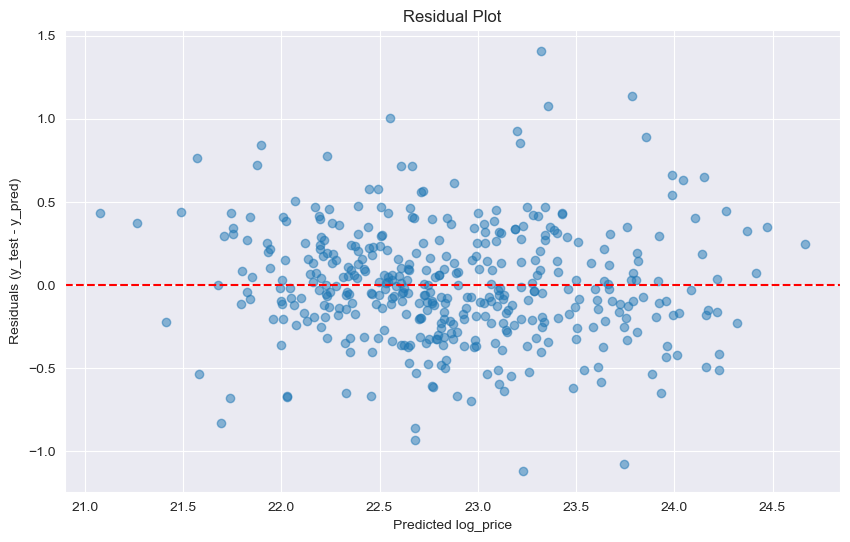


Residual Stats (Check Bias):
Mean Residual: -0.0002
Std Residual: 0.3450


In [ ]:
df = pd.read_csv("data_for_training_final.csv")
# Chuẩn bị dữ liệu
X = df.drop('log_price', axis=1)
y = df['log_price']
feature_columns = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scale dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Tuning hyperparameters với GridSearchCV mở rộng
param_grid = {
    'hidden_layer_sizes': [(100,50), (100,100,50)],
    'alpha': [0.0001, 0.001],
    'activation': ['relu', 'tanh'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.0001, 0.001]
}
grid = GridSearchCV(
    MLPRegressor(max_iter=4000, random_state=42, early_stopping=True, validation_fraction=0.1),
    param_grid,
    cv=6,
    scoring='r2'
)
grid.fit(X_train_scaled, y_train)
if hasattr(grid, 'best_params_'):
    print("Best parameters found:", grid.best_params_)
else:
    grid.best_params_ = {'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.001}
# Huấn luyện mô hình MLP với best params
mlp = MLPRegressor(
    **grid.best_params_,
    max_iter=4000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp.fit(X_train_scaled, y_train)
print("...Huấn luyện hoàn tất.")

# Đánh giá mô hình
y_pred_log = mlp.predict(X_test_scaled)

mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

print("\n--- ĐÁNH GIÁ MÔ HÌNH ---")
print(f"Đánh giá trên thang đo Logarit (dùng để huấn luyện):")
print(f"  R-squared (R2): {r2_log:.4f}")
print(f"  Mean Absolute Error (MAE): {mae_log:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_log:.4f}")

# Đánh giá trên thang đo giá thực
y_test_real = np.exp(y_test)
y_pred_real = np.exp(y_pred_log)
mae_real = mean_absolute_error(y_test_real, y_pred_real)

print(f"\nĐánh giá trên thang đo Giá Thực (VND):")
print(f"  Mean Absolute Error (Giá thực): {mae_real:,.0f} VND")

# Lưu mô hình
joblib.dump(mlp, 'mlp_model4.pkl')
joblib.dump(scaler, 'scaler4.pkl')
joblib.dump(feature_columns, 'feature_columns4.pkl')

# Plot residual
residuals = y_test - y_pred_log
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_log, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted log_price')
plt.ylabel('Residuals (y_test - y_pred)')
plt.title('Residual Plot')
plt.show()
print("\nResidual Stats (Check Bias):")
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Std Residual: {np.std(residuals):.4f}")